In [236]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
from itertools import compress

In [406]:
df=pd.read_csv('./results-20200306-160842.csv')
# results-20200312-120025

In [407]:
df['next_medium'][df['next_medium'].isna()]='NULL'

df.head()

,medium,next_medium,cnt,ratio
0,(none),(none),83867,0.1939
1,(none),(not set),379,0.0009
2,(none),CRM,181,0.0004
3,(none),NULL,303682,0.7021
4,(none),Social,9,0.0000


In [408]:
print('medium from size: ', len(df['medium'].unique()))
print('medium to size: ',len(df['next_medium'].unique()))

medium from size:  53
medium to size:  41


# Completing the DataFrame 
## With all possible mediuns, next_mediuns, conversion and nulls

In [409]:
# mediuns= dict()
# mediuns['total_mediuns']=list(total_mediuns['medium'])
# mediuns['in_medium']=list(df['medium'].unique())
# mediuns['in_next_medium']=list(df['next_medium'].unique())
# mediuns['not_in_next_medium']=list(set(df['medium'].unique().tolist()).difference(df['next_medium'].unique().tolist()))

In [410]:
for ii in range(len(df['medium'].unique())):
    list_next_mediuns=list(set(df['medium'].unique().tolist()) - set(df['next_medium'].loc[df['medium']==df['medium'].unique()[ii]].tolist()))
    for jj in range(len(list_next_mediuns)):
        df=df.append({'medium' : df['medium'].unique()[ii] , 'next_medium' : list_next_mediuns[jj] , 'cnt' : 0, 'ratio' :0} , ignore_index=True)

In [411]:
# tot_null_cnt=df['cnt'][df['next_medium']=='NULL'].sum()
# tot_cv_cnt=df['cnt'][df['next_medium']=='conversion'].sum()

# df=df.append({'medium' : 'conversion' , 'next_medium' : 'conversion' , 'cnt' : tot_cv_cnt, 'ratio' :1} , ignore_index=True)
# df=df.append({'medium' : 'NULL' , 'next_medium' : 'NULL' , 'cnt' : tot_null_cnt, 'ratio' :1} , ignore_index=True)
df=df.append({'medium' : 'conversion' , 'next_medium' : 'conversion' , 'cnt' : 0, 'ratio' :1} , ignore_index=True)
df=df.append({'medium' : 'NULL' , 'next_medium' : 'NULL' , 'cnt' : 0, 'ratio' :1} , ignore_index=True)

print('medium from size: ', len(df['medium'].unique()))
print('medium to size: ',len(df['next_medium'].unique()))

medium from size:  55
medium to size:  55


## Creating the source and target categories to between the mediuns 

In [412]:
total_mediuns=pd.DataFrame()
total_mediuns['medium']=pd.unique(df[['medium','next_medium']].values.ravel('K'))
total_mediuns['categorical']=pd.Categorical(total_mediuns['medium']).codes
total_mediuns.head()

,medium,categorical
0,(none),0
1,(not set),1
2,25136670062_2-,2
3,25736130062_2-,3
4,25736300062_2-,4


In [413]:
df=pd.merge(df,total_mediuns,left_on='medium', right_on='medium')
df.rename(columns={'categorical':'source'},inplace=True)
df.head()

,medium,next_medium,cnt,ratio,source
0,(none),(none),83867,0.1939,0
1,(none),(not set),379,0.0009,0
2,(none),CRM,181,0.0004,0
3,(none),NULL,303682,0.7021,0
4,(none),Social,9,0.0000,0


In [414]:
df['target']=df['source']
for ii in range(len(df['next_medium'])):
    df['target'][ii]=total_mediuns.loc[total_mediuns['medium'] == df['next_medium'][ii], 'categorical'].values[0]
# df['color']='#262C46'
df.head()

,medium,next_medium,cnt,ratio,source,target
0,(none),(none),83867,0.1939,0,0
1,(none),(not set),379,0.0009,0,1
2,(none),CRM,181,0.0004,0,7
3,(none),NULL,303682,0.7021,0,11
4,(none),Social,9,0.0000,0,16


In [415]:
# data_trace = dict(
#     type='sankey',
#     domain = dict(
#       x =  [0,1],
#       y =  [0,1]
#     ),
#     orientation = "h",
#     valueformat = ".0f",
#     node = dict(
#       pad = 10,
#       thickness = 30,
#       line = dict(
#         color = "black",
#         width = 0.5
#       ),
#       label =  df['medium'].dropna(axis=0, how='any'),
#       color = df['color']
#     ),
#     link = dict(
#       source = df['source'].dropna(axis=0, how='any'),
#       target = df['target'].dropna(axis=0, how='any'),
#       value = df['ratio'].dropna(axis=0, how='any'),
#   )
# )



# layout =  dict(
#     title = "Marketing Channels",
#     height = 772,
#     width = 950,
#     font = dict(
#       size = 10
#     ),    
# )

In [416]:
#isso trava tudo... ñ consigo fazer o sankey
# fig = go.Figure(data=[go.Sankey(data_trace)], layout=layout)
# fig.show()

## Filtering DataFrame

In [417]:
df_table=df.pivot_table(index='next_medium',columns='medium',values=['cnt','ratio'])
df_table=df_table.fillna(0)
print('Total shape: ',df_table.shape)

Total shape:  (55, 110)


In [418]:
# chosing channels do exclude
a=list()
channels = [channel for channel in df_table['cnt'].columns if channel not in ['NULL','conversion']] #channels to be removed
for channel in channels:
    a.append(np.sum(df['cnt'][df['medium']==channel]))

S=sum(a)
thresh=S*0.01 # 1%
#thresh=0
print('Count of minimum interactions to take into account: ', round(thresh),' of a total of', S)

non_removal_channels=list(compress(channels, np.asarray(a)>thresh))
removal_channels=list(compress(channels, np.asarray(a)<thresh))
for ii in range(len(np.asarray(a)[np.where(np.asarray(a)>thresh)[0]])):
    print('Channel: ',non_removal_channels[ii],' num: ', np.asarray(a)[np.where(np.asarray(a)>thresh)[0]][ii])

#fil=np.asarray(a)>thresh
print('Channels to be removed: ',removal_channels)

Count of minimum interactions to take into account:  60470.0  of a total of 6046974
Channel:  (none)  num:  432509
Channel:  af  num:  145852
Channel:  cpc  num:  2262013
Channel:  dp  num:  1080526
Channel:  em  num:  676866
Channel:  organic  num:  789174
Channel:  re  num:  348764
Channel:  referral  num:  65511
Channels to be removed:  ['(not set)', '25136670062_2-', '25736130062_2-', '25736300062_2-', 'Affiliates', 'AmigãoSecreto', 'CRM', 'Card', 'Facebook.post', 'Instagram.post', 'OCUPOM', 'PASTA ENVELOPE', 'Post', 'Richmedia', 'Social', 'afiliados', 'app', 'banner_b2b', 'blog', 'blog_VanDuarte', 'botao_materia', 'br', 'carnaval', 'cpm', 'cupom', 'dafiti', 'deeplink_generator', 'display', 'e', 'fb', 'fb-trade', 'fd', 'ff-mid', 'igtv_1x1_cpm', 'off', 'pa', 'ppc', 'produto', 'pwww.dafiti.com.br/kmdevantagensa', 'search', 'siteoficial', 'skechers_coop', 'sm', 'xml', 'zalo']


In [420]:
#removind channels
df_table_ratio=df_table['ratio']
df_table_cnt=df_table['cnt']
for channel in removal_channels:
        df_table_cnt = df_table_cnt.drop(channel, axis=1).drop(channel, axis=0) #Remove one channel each time
        df_table_ratio = df_table_ratio.drop(channel, axis=1).drop(channel, axis=0) #Remove one channel each time
print('Final shape (removed non important channels): ',df_table_ratio.shape)
df_table=df_table_ratio
df_table_cnt['NULL']['NULL']=df_table_cnt.loc['NULL'].sum()
df_table_cnt['conversion']['conversion']=df_table_cnt.loc['conversion'].sum()

Final shape (removed non important channels):  (10, 10)


In [449]:
df_table_cnt

medium,(none),NULL,af,conversion,cpc,dp,em,organic,re,referral
next_medium,,,,,,,,,,
(none),83867.0,0.0,0.0,0.0,38.0,5.0,9.0,21.0,5.0,2.0
NULL,303682.0,3149978.0,76866.0,0.0,1186774.0,807148.0,251253.0,424530.0,81303.0,18422.0
af,1075.0,0.0,39905.0,0.0,9519.0,1085.0,4334.0,5157.0,1534.0,2962.0
conversion,8005.0,0.0,4004.0,80885.0,27994.0,11580.0,11333.0,11668.0,5386.0,915.0
cpc,16333.0,0.0,7751.0,0.0,793209.0,6845.0,23375.0,139613.0,19066.0,3600.0
dp,3100.0,0.0,1287.0,0.0,7009.0,226400.0,2263.0,2650.0,3473.0,423.0
em,5657.0,0.0,4565.0,0.0,28480.0,2873.0,354608.0,11169.0,10400.0,3667.0
organic,7292.0,0.0,4105.0,0.0,165864.0,2213.0,8467.0,177502.0,5597.0,1166.0
re,1210.0,0.0,1969.0,0.0,25805.0,5706.0,13171.0,10021.0,195599.0,20504.0


In [328]:
# channels = [channel for channel in df_table_cnt.columns if channel not in ['NULL','conversion']] #channels to be removed
# total_cv=np.sum(df_table_cnt.loc['conversion',:][channels]) #total conversion in counts
# removal_to_null_cv = df_table_cnt.loc[
#     ['NULL', 'conversion'],:].drop(['NULL', 'conversion'], axis=1) # NULL and Conversion by channel
# removal_to_null_cv.loc['conversion']

In [439]:
channels = [channel for channel in df_table_cnt.columns if channel not in ['NULL','conversion']] #channels to be removed
total_cv=np.sum(df_table_cnt.loc['conversion'][channels]) #total conversion in counts
average_cv=total_cv/len(channels) # Channel average conversion count
##
removal_to_null_cv = df_table_cnt.loc[
    ['NULL', 'conversion']].drop(['NULL', 'conversion'], axis=1) # NULL and Conversion by channel
        # calculate convesion vector
# cv_rate=np.sum(removal_to_null_cv.loc['conversion'])/np.sum(removal_to_null_cv.loc['NULL'])
cv_rate=np.sum(removal_to_null_cv.loc['conversion'])/(np.sum(removal_to_null_cv.loc['NULL'])
                                                     +np.sum(removal_to_null_cv.loc['conversion']))
##
# cv_rate=np.sum(df_table_cnt['conversion'][channels])/np.sum(df_table_cnt['NULL'][channels]) # Conversion / NULL counts
print('Number of conversions: ', total_cv)
print('Average number of conversions per channel:',np.round(average_cv,2))
print('Conversion rate:',np.round(cv_rate,4))

Number of conversions:  80885.0
Average number of conversions per channel: 10110.62
Conversion rate: 0.025


## HeatMap

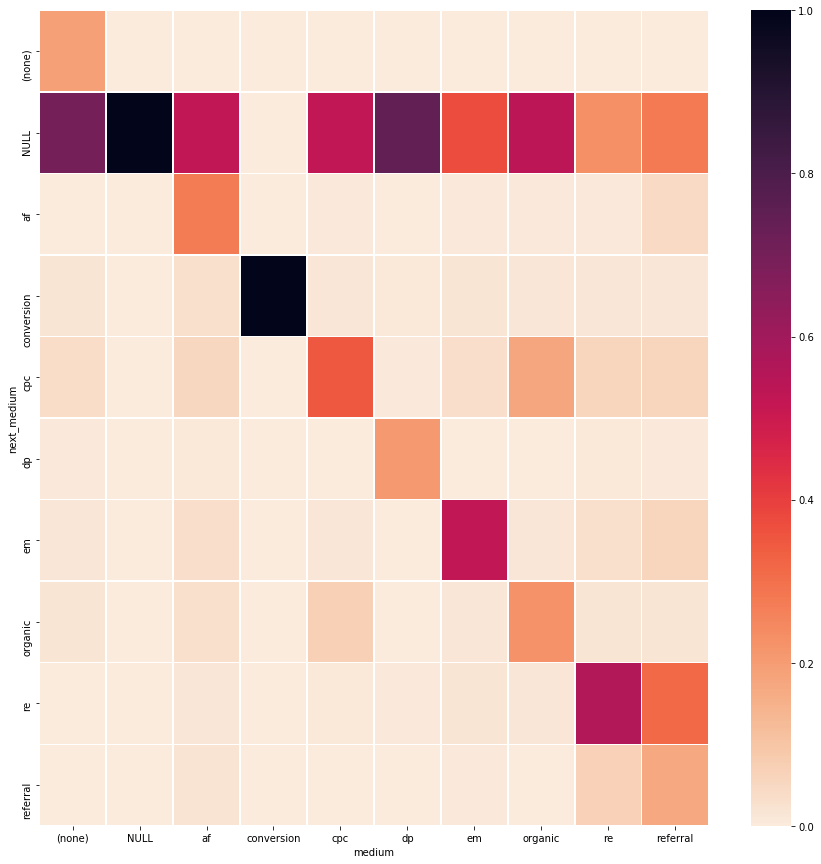

In [440]:
_, ax = plt.subplots(figsize=(15,15))
cmap=cmap = sns.cm.rocket_r
sns.heatmap(df_table_ratio, cmap=cmap, ax=ax, linewidths=.5)
# ax.grid()

# Markov Chain

In [455]:
#average probability of conversion and NULL among all mediuns
channels = [channel for channel in df_table_cnt.columns if channel not in ['NULL','conversion']] #channels to be removed
medium_rates=pd.DataFrame(columns={'medium_cv_rate', 'medium_null_rate', 'medium_cv_null_rate'},index=df_table_cnt.columns)
medium_rates=medium_rates[['medium_cv_rate', 'medium_null_rate', 'medium_cv_null_rate']]
medium_rates=medium_rates.drop(['NULL','conversion'],axis=0)

medium_rates['medium_cv_rate']=df_table_cnt.loc['conversion',:]/(
                                np.sum(df_table_cnt.loc['conversion',:])+np.sum(df_table_cnt.loc['NULL',:]))
medium_rates['medium_null_rate']=df_table_cnt.loc['NULL',:]/(
                                np.sum(df_table_cnt.loc['conversion',:])+np.sum(df_table_cnt.loc['NULL',:]))
medium_rates['medium_cv_null_rate']=df_table_cnt.loc['conversion']/
                                    df_table_cnt.loc['NULL']
medium_rates

,medium_cv_rate,medium_null_rate,medium_cv_null_rate
medium,,,
(none),0.001239,0.046997,0.026360
af,0.000620,0.011896,0.052091
cpc,0.004332,0.183662,0.023588
dp,0.001792,0.124912,0.014347
em,0.001754,0.038883,0.045106
organic,0.001806,0.065699,0.027485
re,0.000834,0.012582,0.066246
referral,0.000142,0.002851,0.049669


In [537]:
df_table_cnt.div(df_table_cnt.sum(axis=0), axis=1) # on columns

medium,(none),NULL,af,conversion,cpc,dp,em,organic,re,referral
next_medium,,,,,,,,,,
(none),0.194809,0.0,0.000000,0.0,0.000017,0.000005,0.000013,0.000027,0.000014,0.000032
NULL,0.705402,1.0,0.534683,0.0,0.527863,0.758535,0.373447,0.541875,0.234631,0.291968
af,0.002497,0.0,0.277581,0.0,0.004234,0.001020,0.006442,0.006582,0.004427,0.046944
conversion,0.018594,0.0,0.027852,1.0,0.012451,0.010883,0.016845,0.014893,0.015543,0.014502
cpc,0.037939,0.0,0.053916,0.0,0.352810,0.006433,0.034743,0.178204,0.055022,0.057056
dp,0.007201,0.0,0.008952,0.0,0.003118,0.212764,0.003364,0.003382,0.010023,0.006704
em,0.013140,0.0,0.031754,0.0,0.012668,0.002700,0.527068,0.014256,0.030013,0.058118
organic,0.016938,0.0,0.028555,0.0,0.073774,0.002080,0.012585,0.226565,0.016152,0.018480
re,0.002811,0.0,0.013696,0.0,0.011478,0.005362,0.019577,0.012791,0.564475,0.324965


In [543]:
def removal_effects(df, cv_rate,n_steps):
    # df=df.div(df.sum(axis=1), axis=0) # on rows
    df=df.div(df.sum(axis=0), axis=1) # on columns
    df[df.isna()]=0
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['NULL','conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0) #Drop each channel
        # removal_df=removal_df.div(removal_df.sum(axis=0),axis=1) #re-normalize on columns
        removal_df[removal_df.isna()]=0
        columns=removal_df.columns
        index=removal_df.index

        rm_TM0=removal_df.values
        rm_TM=rm_TM0
        for _ in range(0,n_steps):
            rm_TM=rm_TM @ rm_TM0 # progating n_steps maximum
        
        # logger.debug(rm_TM)

        W,v=np.linalg.eig(rm_TM)
        removal_df=pd.DataFrame(rm_TM,columns=columns,index=index)
        removal_to_null_cv = removal_df.loc[
            ['NULL', 'conversion']].drop(['NULL', 'conversion'], axis=1) # NULL and Conversion by channel

        
        # logger.debug(removal_to_null_cv)

        # calculate convesion vector
        # rm_cv_rate=np.sum(removal_to_null_cv.loc['conversion'])/np.sum(removal_to_null_cv.loc['NULL'])
        rm_cv_rate=np.sum(removal_to_null_cv.loc['conversion'])/(np.sum(removal_to_null_cv.loc['NULL'])+
                                                                 np.sum(removal_to_null_cv.loc['conversion']))
        
        # logger.debug(rm_cv_rate)


        removal_effect = rm_cv_rate / cv_rate -1
        removal_effects_dict[channel] = np.round(removal_effect,3)
        # <cv_vec|rm_TM| vf> -> projection of eig.vector in conversion vector
        # conversion value for channel removal
        
    return removal_effects_dict,W,v

In [544]:
rm_eff_dict,W,v=removal_effects(df_table_cnt, cv_rate,n_steps=0)
rm_eff_dict
# ((np.asarray(list(rm_eff_dict.values())))+1.0)*cv_rate

{'(none)': 0.337,
 'af': 0.171,
 'cpc': 0.337,
 'dp': 0.447,
 'em': 0.235,
 'organic': 0.315,
 're': 0.204,
 'referral': 0.233}

In [540]:
W

array([1.        , 1.        , 0.58605561, 0.51636442, 0.41320975,
       0.27454335, 0.15868667, 0.21240909, 0.19480324])

In [545]:
 n_steps=15
 columns=['step_'+str(step+1) for step in range(n_steps)]
 df_rm_step=pd.DataFrame(columns=columns,index=df_table_ratio.index)
 for step in range(n_steps):
    rm_eff_dict,_,_=removal_effects(df_table_cnt, cv_rate,n_steps=step)
    df_rm_step[columns[step]]=pd.DataFrame.from_dict(rm_eff_dict,orient='index')
df_rm_step=df_rm_step.drop(['NULL', 'conversion'], axis=0) # NULL and Conversion by channel

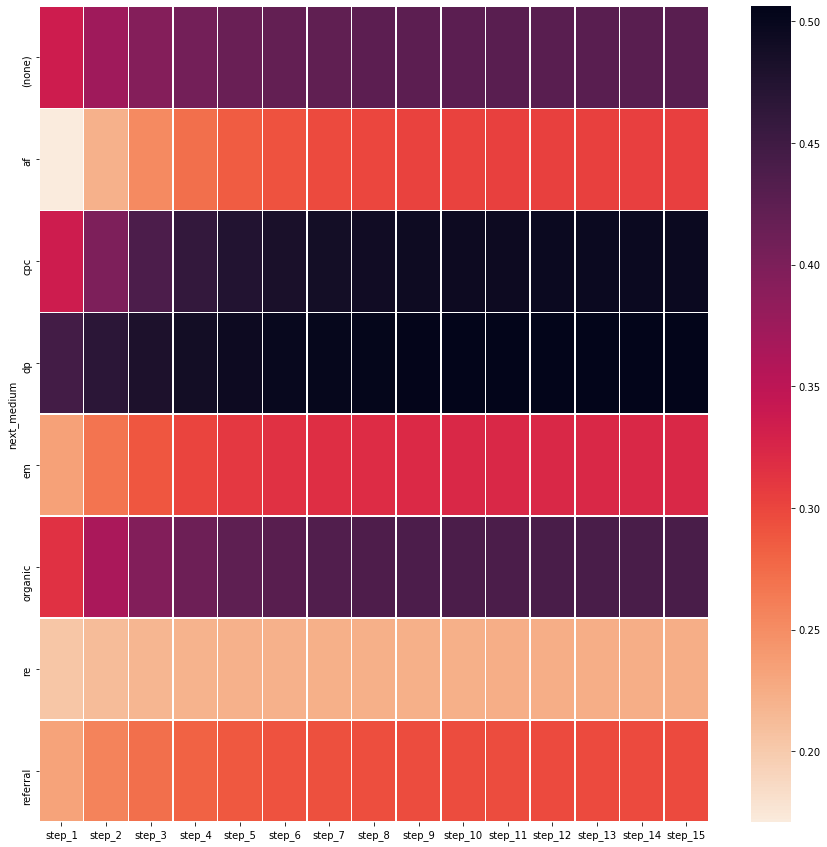

In [546]:
#after removal
_, ax = plt.subplots(figsize=(15,15))
cmap=cmap = sns.cm.rocket_r
sns.heatmap(df_rm_step, cmap=cmap, ax=ax, linewidths=.5)
# ax.grid()

In [213]:
# removal_df = df_table_cnt.drop(channel, axis=1).drop(channel, axis=0) #Drop each channel
# removal_df=removal_df.div(removal_df.sum(axis=1),axis=0) #re-normalize on rows
# removal_df[removal_df.isna()]=0
# removal_df



In [522]:
removal_df[channels[7]] # sem RE

next_medium
(none)        0.000047
NULL          0.432523
af            0.069544
conversion    0.021483
cpc           0.084523
dp            0.009931
em            0.086096
organic       0.027376
referral      0.268478
Name: referral, dtype: float64

In [520]:
 removal_df[channels[7]] # com RE

next_medium
(none)        0.000033
NULL          0.306349
conversion    0.015216
cpc           0.059866
dp            0.007034
em            0.060980
organic       0.019390
re            0.340972
referral      0.190159
Name: referral, dtype: float64

In [523]:
removal_df = df_table_cnt.drop(channels[6], axis=1).drop(channels[6], axis=0) #Drop each channel
# removal_df = df_table_cnt.drop(channels[1], axis=1).drop(channels[1], axis=0) #Drop each channel
removal_df=removal_df.div(removal_df.sum(axis=0),axis=1) #re-normalize on columns
removal_to_null_cv = removal_df.loc[
    ['NULL', 'conversion']].drop(['NULL', 'conversion'], axis=1) # NULL and Conversion by channel
        # calculate convesion vector
rm_cv_rate=np.sum(removal_to_null_cv.loc['conversion'])/(np.sum(removal_to_null_cv.loc['NULL'])+
                                                                 np.sum(removal_to_null_cv.loc['conversion']))
removal_to_null_cv.sum(1)

next_medium
NULL          3.908437
conversion    0.124173
dtype: float64

In [524]:
print('sum of cv: ',np.sum(removal_to_null_cv.loc['conversion']))
print('sum of NULLs: ', np.sum(removal_to_null_cv.loc['NULL']))
print('rm_cv_rate: ',rm_cv_rate)
print('cv_rate: ', cv_rate)
print('removal_effect :',rm_cv_rate/cv_rate -1)

sum of cv:  0.12417269000099403
sum of NULLs:  3.908436907589433
rm_cv_rate:  0.03079214265501673
cv_rate:  0.025035106719164507
removal_effect : 0.2299585138754443


In [230]:
1- cv_rate/rm_cv_rate

0.3869013437666988